In [1]:
using Rocket, ReactiveMP, GraphPPL, Distributions
using BenchmarkTools, Random, Plots

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1423


In [2]:
@model function smoothing(n, x0, c::ConstVariable, P::ConstVariable)
    
    x_prior ~ NormalMeanVariance(mean(x0), cov(x0)) 

    x = randomvar(n)
    y = datavar(Float64, n)
    
    x_prev = x_prior
    
    for i in 1:n
        x[i] ~ x_prev + c
        y[i] ~ NormalMeanVariance(x[i], P)
        
        x_prev = x[i]
    end

    return x, y
end

smoothing (generic function with 1 method)

In [3]:
seed = 123

rng = MersenneTwister(seed)

P = 100.0

# For large `n` apply: smoothing(..., options = (limit_stack_depth = 500, ))
n = 500

hidden = collect(1:n)
data   = hidden + rand(rng, Normal(0.0, sqrt(P)), n);

In [4]:
x0_prior = NormalMeanVariance(0.0, 10000.0)

NormalMeanVariance{Float64}(μ=0.0, v=10000.0)

In [5]:
(posteriors, _) = inference(model = () -> smoothing(n, x0_prior, 1.0, P), data  = (y = data, ), returnvars = (x = KeepLast(), ),)

Inference results:
-----------------------------------------
x = Marginal[Marginal(NormalWeightedMeanPrecision{Float64}(xi=7.0355954390945605, w=...


In [6]:
function custom_inference(data, x0, P)
    n = length(data)
    
    _, (x, y) = smoothing(n, x0, 1.0, P);

    x_buffer  = buffer(Marginal, n)
    marginals = getmarginals(x)
    
    subscription = subscribe!(marginals, x_buffer)
    
    update!(y, data)
    
    unsubscribe!(subscription)
    
    return getvalues(x_buffer)
end

custom_inference (generic function with 1 method)

In [7]:
results = custom_inference(data, x0_prior, P);

In [8]:
@assert all(results .== posteriors[:x])

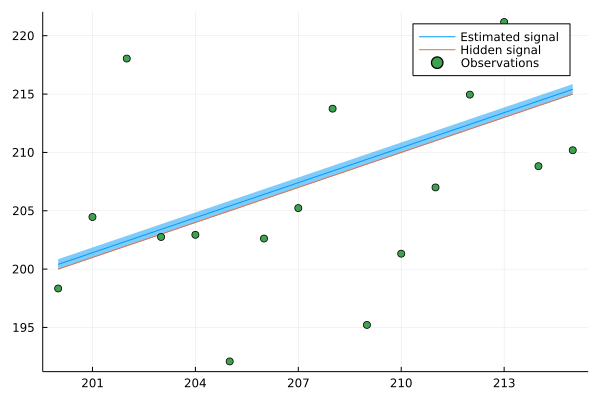

In [9]:
let 
    subrange = 200:215
    
    m = mean.(results)[subrange]
    s = std.(results)[subrange]
    
    p = plot()
    
    p = plot!(subrange, m, ribbon = s, label = "Estimated signal")
    p = plot!(subrange, hidden[subrange], label = "Hidden signal")
    p = scatter!(subrange, data[subrange], label = "Observations")
    
    plot(p)
end

In [10]:
@benchmark res = inference(model = () -> smoothing($n, $x0_prior, 1.0, $P), data  = (y = $data, ), returnvars = (x = KeepLast(), ),)

BenchmarkTools.Trial: 307 samples with 1 evaluation.
 Range (min … max):  12.753 ms … 32.830 ms  ┊ GC (min … max):  0.00% … 48.93%
 Time  (median):     14.411 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   16.288 ms ±  4.886 ms  ┊ GC (mean ± σ):  10.07% ± 15.35%

   ▆▅▃█▃▁▂                                                     
  ▄███████▆▆▆▅▃▃▃▃▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▃▃▂▂▃▃▂▄▁▃▃▃▂▃▂▃ ▃
  12.8 ms         Histogram: frequency by time        30.7 ms <

 Memory estimate: 9.86 MiB, allocs estimate: 199676.

In [11]:
@benchmark res = custom_inference($data, $x0_prior, $P)

BenchmarkTools.Trial: 313 samples with 1 evaluation.
 Range (min … max):  12.947 ms … 30.963 ms  ┊ GC (min … max): 0.00% … 51.54%
 Time  (median):     14.311 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   15.974 ms ±  4.582 ms  ┊ GC (mean ± σ):  9.84% ± 15.12%

   ▅█▂▁▁                                                       
  ▇██████▆▆▆▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▂▃▃▃▃▃▃▁▃▂ ▃
  12.9 ms         Histogram: frequency by time        29.9 ms <

 Memory estimate: 9.84 MiB, allocs estimate: 199623.